### 1. Pré-processamento

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import gc

# Limpar memória
gc.collect()

# Carregar dados
df = pd.read_csv("../outputs/clean_dataset.csv")

# Criar variável Claim Cost
df['claim_cost'] = df['has_claim'] * df['claim_severity']

# Selecionar features iniciais
features = [
    'age', 'gender', 'marital_status', 'occupation', 'income_level',
    'education_level', 'geo_info', 'location', 'coverage_amount',
    'premium_amount', 'deductible', 'policy_type', 'claim_history',
    'risk_profile', 'prev_claims', 'credit_score'
]


In [2]:
### 2. Seleção de variáveis significativa

In [3]:
# Numéricas – correlação com claim_cost
numeric_features = ['age', 'income_level', 'coverage_amount', 'premium_amount',
                    'deductible', 'claim_history', 'prev_claims', 'credit_score',
                    'claim_frequency', 'claim_severity']

corr = df[numeric_features + ['claim_cost']].corr()['claim_cost'].sort_values(ascending=False)
print("Correlação com claim_cost:\n", corr)


# Categóricas – diferença de médias
categorical_features = ['gender','marital_status','occupation','education_level','policy_type','risk_profile']

# Média claim_cost por categoria
for col in categorical_features:
    print(df.groupby(col)['claim_cost'].mean().sort_values(ascending=False))

Correlação com claim_cost:
 claim_severity     1.000000
claim_cost         1.000000
claim_history      0.789548
coverage_amount    0.004191
age               -0.002225
credit_score      -0.003793
income_level      -0.007050
deductible        -0.007624
premium_amount    -0.026722
prev_claims       -0.489162
claim_frequency   -0.489162
Name: claim_cost, dtype: float64
gender
Male      1.752918
Female    1.729753
Name: claim_cost, dtype: float64
marital_status
Separated    1.803860
Widowed      1.779222
Divorced     1.735432
Married      1.728320
Single       1.672721
Name: claim_cost, dtype: float64
occupation
Teacher         1.801360
Entrepreneur    1.798749
Nurse           1.763437
Doctor          1.759914
Engineer        1.744887
Salesperson     1.726502
Manager         1.709001
Lawyer          1.702193
Artist          1.668843
Name: claim_cost, dtype: float64
education_level
Associate Degree       1.817599
Bachelor's Degree      1.751664
Master's Degree        1.739092
Doctorate     

### 3. Criar dataset final com variáveis selecionadas

In [4]:
# Variáveis numéricas selecionadas com maior correlação
selected_numeric = ['claim_severity', 'claim_history', 'prev_claims', 'claim_frequency']

# Variáveis categóricas significativas
selected_categorical = ['marital_status', 'occupation', 'education_level', 'policy_type', 'risk_profile']

# One-hot encoding apenas das categóricas selecionadas
df_model = pd.get_dummies(df[selected_numeric + selected_categorical + ['claim_cost']], drop_first=True).astype(np.float32)

# Separar features e target
X = df_model.drop('claim_cost', axis=1)
y = df_model['claim_cost']

# Dividir treino/teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 4. GLM Tweedie

In [5]:
# Adicionar constante para intercepto
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Definir modelo Tweedie
tweedie_model = sm.GLM(y_train, X_train_const, family=sm.families.Tweedie(var_power=1.5, link=sm.families.links.Log()))
tweedie_results = tweedie_model.fit()

print(tweedie_results.summary())

# Previsão
y_pred = tweedie_results.predict(X_test_const)

# Métricas
from sklearn.metrics import mean_squared_error, r2_score
print(f"MSE Tweedie: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Tweedie: {r2_score(y_test, y_pred):.4f}")

# ### Tweedie otimizado com transformações log

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# Log-transform para variáveis contínuas assimétricas
for col in ['coverage_amount', 'premium_amount', 'deductible']:
    df[col+'_log'] = np.log1p(df[col])

# Selecionar variáveis finais para o modelo Tweedie
selected_numeric = ['claim_severity', 'claim_history', 'prev_claims', 'claim_frequency',
                    'coverage_amount_log', 'premium_amount_log', 'deductible_log']
selected_categorical = ['marital_status', 'occupation', 'education_level', 'policy_type', 'risk_profile']

# One-hot encoding das categóricas
df_model = pd.get_dummies(df[selected_numeric + selected_categorical + ['claim_cost']], drop_first=True).astype(np.float32)

# Separar features e target
X = df_model.drop('claim_cost', axis=1)
y = df_model['claim_cost']

# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adicionar constante para intercepto
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Definir modelo Tweedie (var_power=1.5) com link log
tweedie_model = sm.GLM(y_train, X_train_const, family=sm.families.Tweedie(var_power=1.5, link=sm.families.links.Log()))
tweedie_results = tweedie_model.fit()

# Resumo do modelo
print(tweedie_results.summary())

# Previsão
y_pred = tweedie_results.predict(X_test_const)

# Métricas
print(f"MSE Tweedie (log-transform): {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Tweedie (log-transform): {r2_score(y_test, y_pred):.4f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             claim_cost   No. Observations:                42802
Model:                            GLM   Df Residuals:                    42778
Model Family:                 Tweedie   Df Model:                           23
Link Function:                    Log   Scale:                         0.24245
Method:                          IRLS   Log-Likelihood:                -68934.
Date:                Mon, 18 Aug 2025   Deviance:                       22831.
Time:                        19:01:37   Pearson chi2:                 1.04e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.9907
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### 5. Redes Neurais

Epoch 1/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1735 - val_loss: 0.0143
Epoch 2/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0088 - val_loss: 0.0063
Epoch 3/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 4/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 5/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0011 - val_loss: 8.1569e-04
Epoch 7/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.0540e-04 - val_loss: 5.9942e-04
Epoch 8/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.8172e-04 - val_loss: 4.1321e-04
Epoch 9/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0060e-04 - val_loss: 3.2581e-04
Epoch 10/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.2459e-04 - val_loss: 4.6435e-04
Epoch 11/200
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.0667e-0

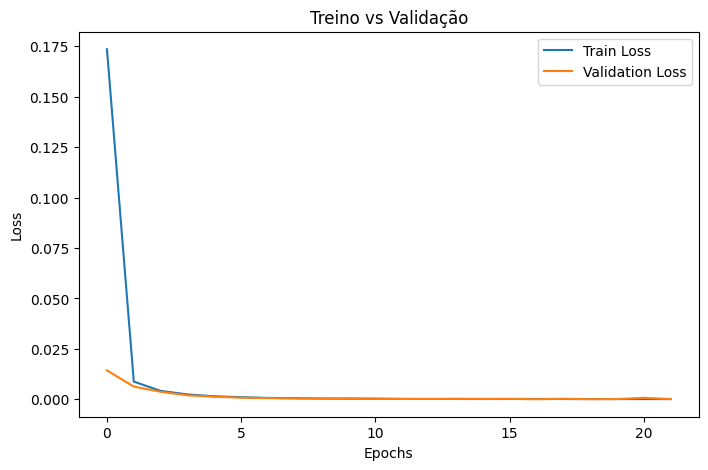

1338/1338 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
           RMSE        R2       MAE
Train  0.007308  0.999977  0.005787
Test   0.007341  0.999977  0.005779


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input

# Padronização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criar o modelo usando Input
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # camada de entrada explícita
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # saída contínua
])

# Compilar
model.compile(optimizer='adam', loss='mse')

# Definir o callback
early_stop = EarlyStopping(
    monitor='val_loss',      # observa a perda de validação
    patience=5,             # espera 10 epochs sem melhora
    restore_best_weights=True  # volta para os melhores pesos
)

# Treinar o modelo com Early Stopping
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]   # aqui adicionamos o early stopping
)

# Plot do loss para avaliar overfitting
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Treino vs Validação')
plt.legend()
plt.show()

# -------------------------
# Estatísticas de avaliação
# -------------------------

# Previsões
y_pred_train = model.predict(X_train_scaled).flatten()
y_pred_test = model.predict(X_test_scaled).flatten()

# Métricas
metrics = {
    'RMSE': [mean_squared_error(y_train, y_pred_train)**0.5,
             mean_squared_error(y_test, y_pred_test)**0.5],
    'R2': [r2_score(y_train, y_pred_train),
           r2_score(y_test, y_pred_test)],
    'MAE': [mean_absolute_error(y_train, y_pred_train),
            mean_absolute_error(y_test, y_pred_test)]
}

# Criar tabela
evaluation_df = pd.DataFrame(metrics, index=['Train', 'Test'])
print(evaluation_df)
